<a href="https://colab.research.google.com/github/mohammel-debug/hmm-pos-tagger/blob/main/Implement_an_HMM_PoS_tagger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Implementing an HMM PoS tagger**


---

*Authors: Josu Barrutia, Bersun Sipal, Mohammed El khamlichi, Mikel Molina*

GitHub Link: https://github.com/mohammel-debug/hmm-pos-tagger/tree/main

---

In this notebook, the aim is to implement a Hidden Markov Model (HMM) for part-of-speech tagging. This task consists of assigning a grammatical category to each word in a sentence.

Initially, we will work with the CHILDES and EWT datasets, both of which are belong to the Universal Dependencies (UD) project and already split into training, development and test sets. Therefore, we can proceed directly to the training phase.

**CHILDES (Child Language Data Exchange System)** is a large, open database containing transcripts, audio and video recordings that document how children acquire language in natural settings. It is primarily used in first language acquisition research. We chose this dataset because it is very different from adult corpora. Children use much more basis vocabulary, with smaller lexical range compared to adults. Their speech tends to be highly repetitive (both vocabulary and structure of sentences).

**EWT (English Web Treebank)** is collection of contemporary, adult-producted text taken from various web sources. We chose this dataset because it represent natural adult language and provides high-quality UD annotations.

We will train all our models following the same procedure, storing the necessary frequency counts. However, each model introduces improvements, allowing us to observe how the performance improves at each iteration.

Finally, we will evaluate each model and analyze the results, aiming to understand how the HMM models perform on the dataset.

# **1. Datasets Loading**

### 1.1. Downloading CHILDES and EWT dataset:


In [1]:
import nltk
nltk.download('universal_tagset')
!pip install conllu
# dataset 1: CHILDES
!wget -q https://raw.githubusercontent.com/UniversalDependencies/UD_English-CHILDES/master/en_childes-ud-train.conllu
!wget -q https://raw.githubusercontent.com/UniversalDependencies/UD_English-CHILDES/master/en_childes-ud-dev.conllu
!wget -q https://raw.githubusercontent.com/UniversalDependencies/UD_English-CHILDES/master/en_childes-ud-test.conllu


# dataset 2: Web Text (EWT)
# Download EWT dataset with exact filenames
!wget -O /content/en_ewt-ud-train.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-train.conllu
!wget -O /content/en_ewt-ud-dev.conllu   https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-dev.conllu
!wget -O /content/en_ewt-ud-test.conllu  https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-test.conllu

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


--2025-11-30 15:18:57--  https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-train.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15029817 (14M) [text/plain]
Saving to: ‘/content/en_ewt-ud-train.conllu’

/content/en_ewt-ud- 100%[===================>]  14.33M  77.7MB/s    in 0.2s    

2025-11-30 15:18:58 (77.7 MB/s) - ‘/content/en_ewt-ud-train.conllu’ saved [15029817/15029817]

--2025-11-30 15:18:58--  https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-dev.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connec

Next, we open and store all the partitioned datasets from CHILDES.

In [2]:
data_train_childes = open("/content/en_childes-ud-train.conllu", "r", encoding="utf-8").read()
data_dev_childes = open("/content/en_childes-ud-dev.conllu", "r", encoding="utf-8").read()
data_test_childes = open("/content/en_childes-ud-test.conllu", "r", encoding="utf-8").read()

print("There are {} sentences in the training set.".format(len(data_train_childes)))
print("There are {} sentences in the testing set.".format(len(data_test_childes)))
print("There are {} sentences in the development set.".format(len(data_dev_childes)))

There are 19558483 sentences in the training set.
There are 5194505 sentences in the testing set.
There are 2159081 sentences in the development set.


And we do the same for EWT dataset.

In [3]:
data_train_ewt = open("/content/en_ewt-ud-train.conllu", "r", encoding="utf-8").read()
data_dev_ewt = open("/content/en_ewt-ud-dev.conllu", "r", encoding="utf-8").read()
data_test_ewt = open("/content/en_ewt-ud-test.conllu", "r", encoding="utf-8").read()

print("There are {} sentences in the training set.".format(len(data_train_ewt)))
print("There are {} sentences in the testing set.".format(len(data_test_ewt)))
print("There are {} sentences in the development set.".format(len(data_dev_ewt)))

There are 15028897 sentences in the training set.
There are 1899745 sentences in the testing set.
There are 1897963 sentences in the development set.


If we take a look at the content of every file, we can see that they follow a certain format.

In [4]:
print(data_train_childes[:500])
print("----------------------------------")
print(data_train_ewt[:500])

# sent_id = 0
# original_sent_id = 1754162
# s_24_sent_id = 14944
# child_name = Adam
# childes_toks = you won't cut your finger what
# corpus_name = Brown
# gold_annotation = False
# child_age = 41.95363354483665
# child_gender = male
# speaker_role = Investigator
# type = question
# text = You won 't cut your finger what?
1	You	you	PRON	PRP	_	4	nsubj	4:nsubj	_
2	won	will	AUX	VBD	_	4	aux	4:aux	_
3	't	not	PART	RB	_	4	advmod	4:advmod	_
4	cut	cut	VERB	VB	_	0	root	0:root	_
5	your	your	PRON	PRP$	_	6
----------------------------------
# newdoc id = weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000
# sent_id = weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-0001
# newpar id = weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-p0001
# text = Al-Zaman : American forces killed Shaikh Abdullah al-Ani, the preacher at the mosque in the town of Qaim, near the Syrian border.
1	Al	Al	PROPN	NNP	Number=Sing	0	root	0:root	SpaceAfter=No
2	-	-	PUNCT	HYPH	_	3	pun

There are many elements in the file which we can omit, as we only need the sentence and its PoS tags.


# **2. Data Parsing**

## 2.1 Parsing

We establish a method to read from a file. Then, it returns two lists of lists: A list of sentences and a list of PoS tags for every word in those sentences.

In [5]:
def parse_data(file1):

  sentences = []
  pos_tags = []

  current_sent_tokens = []
  current_sent_tags = []

  lines = file1.strip().split('\n')

  for line in lines:
      line = line.strip()

      if line.startswith("#") or not line:
          if current_sent_tokens:
              sentences.append(current_sent_tokens)
              pos_tags.append(current_sent_tags)
              current_sent_tokens = []
              current_sent_tags = []
          continue

      parts = line.split('\t')

      if len(parts) < 4:
          continue

      if '-' in parts[0]:
          continue

      current_sent_tokens.append(parts[1])
      current_sent_tags.append(parts[3])

  if current_sent_tokens:
      sentences.append(current_sent_tokens)
      pos_tags.append(current_sent_tags)

  print(f"Total Sentences found: {len(sentences)}\n")
  return sentences, pos_tags


Once the method is defined, we apply it on the available datasets and store the generated outputs in variables for later use.

In [6]:
# CHILDES dataset
sentences_train_childes, pos_tags_train_childes = parse_data(data_train_childes)
sentences_dev_childes, pos_tags_dev_childes = parse_data(data_dev_childes)
sentences_test_childes, pos_tags_test_childes = parse_data(data_test_childes)

# EWT dataset
sentences_train_ewt, pos_tags_train_ewt = parse_data(data_train_ewt)
sentences_dev_ewt, pos_tags_dev_ewt = parse_data(data_dev_ewt)
sentences_test_ewt, pos_tags_test_ewt = parse_data(data_test_ewt)

Total Sentences found: 34732

Total Sentences found: 3860

Total Sentences found: 9591

Total Sentences found: 12544

Total Sentences found: 2001

Total Sentences found: 2077



Finally, we merge both lists into a list of tuples. Each tuple will be composed of a word and its PoS tag.

In [7]:
tagged_sentences_train_childes = [list(zip(s, p)) for s, p in zip(sentences_train_childes, pos_tags_train_childes)]
tagged_sentences_test_childes = [list(zip(s, p)) for s, p in zip(sentences_test_childes, pos_tags_test_childes)]
tagged_sentences_dev_childes = [list(zip(s, p)) for s, p in zip(sentences_dev_childes, pos_tags_dev_childes)]

tagged_sentences_train_ewt = [list(zip(s, p)) for s, p in zip(sentences_train_ewt, pos_tags_train_ewt)]
tagged_sentences_test_ewt = [list(zip(s, p)) for s, p in zip(sentences_test_ewt, pos_tags_test_ewt)]
tagged_sentences_dev_ewt = [list(zip(s, p)) for s, p in zip(sentences_dev_ewt, pos_tags_dev_ewt)]

## 2.2 The PoS Tagset distribution for both CHILDES and EWT

Now that we have properly loaded the datasets into our variables, we can see the distribution for each of them.

Total number of tags for childes: 17
{'AUX', 'SYM', 'NOUN', 'ADP', 'ADJ', 'CCONJ', 'INTJ', 'NUM', 'PUNCT', 'SCONJ', 'DET', 'ADV', 'PART', 'PRON', 'VERB', 'PROPN', 'X'}


<Axes: xlabel='Samples', ylabel='Counts'>

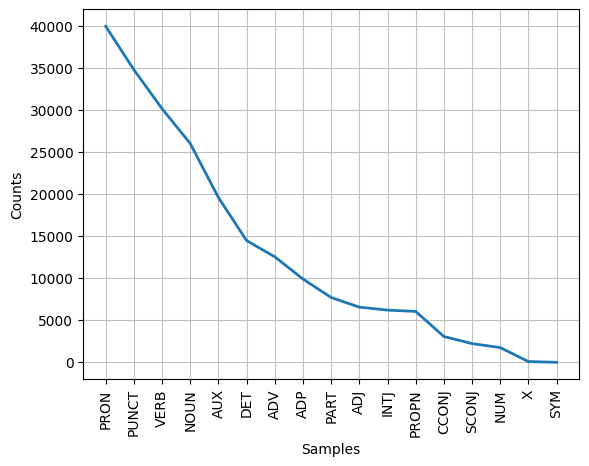

In [8]:
tags = set()
for word_l, tag_l in zip(sentences_train_childes, pos_tags_train_childes):
  for tag in tag_l:
    tags.add(tag)
# retrieve the total number of tags in the tagset and the set of tags
print(f"Total number of tags for childes: {len(tags)}")
print(tags)

tags = list()
for word, tag_l in zip(sentences_train_childes, pos_tags_train_childes):
  for tag in tag_l:
    tags.append(tag)
freq = nltk.FreqDist(tags)
freq.plot()


Total number of tags for ewt: 17
{'AUX', 'SYM', 'ADJ', 'NOUN', 'ADP', 'CCONJ', 'INTJ', 'NUM', 'PUNCT', 'SCONJ', 'DET', 'ADV', 'PART', 'PRON', 'VERB', 'PROPN', 'X'}


<Axes: xlabel='Samples', ylabel='Counts'>

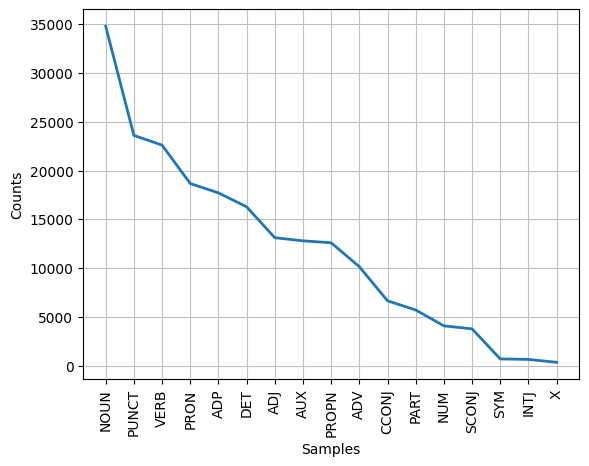

In [9]:

tags_ewt = set()
for word_l, tag_l in zip(sentences_train_ewt, pos_tags_train_ewt):
  for tag in tag_l:
    tags_ewt.add(tag)
# retrieve the total number of tags in the tagset and the set of tags
print(f"Total number of tags for ewt: {len(tags_ewt)}")
print(tags_ewt)

tags_ewt = list()
for word, tag_l in zip(sentences_train_ewt, pos_tags_train_ewt):
  for tag in tag_l:
    tags_ewt.append(tag)
freq = nltk.FreqDist(tags_ewt)
freq.plot()

# **3. Hidden Markov Model Implementations**

As we have already mentioned before, we will first make a simple implementation of an HMM, and then improve it while keeping track of how the accuracy improves. We will see the results both on the CHILDES and EWT dataset

## **3.1 HMM_1**

Every HMM we will implement will follow the same training procedure. However, as a starting point, the Viterbi algorithm will only multiply probabilities rather than sum the log probabilities. The function is defined as follows.

$$
\large
\arg\max_{y \in Y}
\prod_{i=1}^{n+1} p(y_i|y_{i-1}) \prod_{i=1}^{n+1} p(x_i|y_{i})
$$



The only thing we are adding is the Laplace smoothing, which is necessary to prevent zero probabilities, as multiplying them would make the entire sequence probability collapse to zero.

In [10]:
from collections import defaultdict

class HMM_1:
    def __init__(self):
        self.transition = {} # Set of transition probabilities. p(y-1 | y)
        self.emission = {} # Set of emission probabilities. p(y|x)
        self.start_prob = {} # Set of starting probabilities. p(x)

        self.default_transition = {}
        self.default_emission = {}
        self.default_start = 0.0

        self.states = []
        self.vocab = set()

    def train(self, train_data):
        temp_start = defaultdict(int)
        temp_trans = defaultdict(lambda: defaultdict(int))
        temp_emit = defaultdict(lambda: defaultdict(int))
        tag_counts = defaultdict(int)

        # We just store all the frequencies for each sentence we process.
        for sentence in train_data:
            prev_tag = None
            for i, (word, tag) in enumerate(sentence):
                self.vocab.add(word)
                tag_counts[tag] += 1
                temp_emit[tag][word] += 1

                if i == 0:
                    temp_start[tag] += 1
                else:
                    temp_trans[prev_tag][tag] += 1
                prev_tag = tag

        self.states = list(tag_counts.keys())
        vocab_size = len(self.vocab)
        num_states = len(self.states)

        total_starts = sum(temp_start.values()) + num_states
        self.default_start = 1.0 / total_starts

        # Once we have stored all the frequencies, we add them to the attributes and apply smoothing to all of them.

        for tag in self.states:
            if tag in temp_start:
                self.start_prob[tag] = (temp_start[tag] + 1) / total_starts

        for tag in self.states:
            total_obs = tag_counts[tag] + vocab_size
            self.default_emission[tag] = 1.0 / total_obs

            for word, count in temp_emit[tag].items():
                self.emission[(tag, word)] = (count + 1) / total_obs

        for prev_tag in self.states:
            total_trans = sum(temp_trans[prev_tag].values()) + num_states
            self.default_transition[prev_tag] = 1.0 / total_trans

            for next_tag, count in temp_trans[prev_tag].items():
                self.transition[(prev_tag, next_tag)] = (count + 1) / total_trans

    # Viterbi algorithm to make use of the trained HMM model.
    def viterbi(self, sentence):
        if not sentence: return []

        N = len(sentence)
        V = [{}]
        backpointer = [{}]

        # Initialization step.

        first_word = sentence[0]
        for state in self.states:
            emit_p = self.emission.get((state, first_word), self.default_emission.get(state, 1e-10))
            start_p = self.start_prob.get(state, self.default_start)

            V[0][state] = start_p * emit_p
            backpointer[0][state] = None

        # Recursion step.

        for t in range(1, N):
            V.append({})
            backpointer.append({})
            word = sentence[t]

            for curr_state in self.states:
                emit_p = self.emission.get((curr_state, word), self.default_emission.get(curr_state, 1e-10))

                best_prob = -1.0
                best_prev_state = None

                for prev_state in self.states:
                    trans_p = self.transition.get((prev_state, curr_state), self.default_transition.get(prev_state, 1e-10))
                    prob = V[t-1][prev_state] * trans_p # We multiply because we aren't using the log probabilities yet.

                    if prob > best_prob:
                        best_prob = prob
                        best_prev_state = prev_state

                V[t][curr_state] = best_prob * emit_p # For better efficiency we just multiply the emission probability at the end.
                backpointer[t][curr_state] = best_prev_state

        best_final_prob = -1.0
        best_final_state = None
        for s in self.states:
            if V[N-1][s] > best_final_prob:
                best_final_prob = V[N-1][s]
                best_final_state = s

        path = [best_final_state]
        current_state = best_final_state

        # Termination step.

        for t in range(N-1, 0, -1):
            current_state = backpointer[t][current_state]
            path.insert(0, current_state)

        return path

    # Method to evaluate with the model. We return the rate of correctly accepted words over the data.
    def evaluate(self, test_data):
        total = 0
        correct = 0
        for sentence in test_data:
            words = [w for w, t in sentence]
            gold = [t for w, t in sentence]
            pred = self.viterbi(words)

            for p, g in zip(pred, gold):
                if p == g: correct += 1
                total += 1
        return correct / total if total > 0 else 0

### Training and Evaluating the HMM_1 on CHILDES Dataset

In [11]:
hmm_1_childes= HMM_1()
hmm_1_childes.train(tagged_sentences_train_childes)
print("CHILDES Dev Accuracy:", hmm_1_childes.evaluate(tagged_sentences_dev_childes))

CHILDES Dev Accuracy: 0.9194570135746606


### Training and Evaluating the HMM_1 on EWT Dataset

In [12]:
hmm_1_ewt=  HMM_1()
hmm_1_ewt.train(tagged_sentences_train_ewt)
print("EWT dev Accuracy:", hmm_1_ewt.evaluate(tagged_sentences_dev_ewt))

EWT dev Accuracy: 0.8463679376565544


As we can see, the accuracy for the CHILDES dataset is higher than the one in the EWT dataset. We will keep this in mind for a later analysis.

## **3.2 HMM_2**

For this HMM model we will change the function to use the sum of the log probabilities. This way, we expect to see an increase in efficiency, rather than in accuracy.
$$
\large
\arg\max_{y \in Y}
\sum_{i=1}^{n+1} \ln p(y_i|y_{i-1}) \sum_{i=1}^{n+1} \ln p(x_i|y_{i})
$$



In [13]:
from tkinter.constants import NO
from collections import defaultdict
import math

class HMM_2:
    def __init__(self, min_log_prob=-1e9):

        self.min_log_prob = min_log_prob
        self.transition = defaultdict(lambda: defaultdict(lambda: self.min_log_prob))
        self.emission = defaultdict(lambda: defaultdict(lambda: self.min_log_prob))
        self.start_prob = defaultdict(lambda: self.min_log_prob)

        self.tag_counts = defaultdict(int)
        self.states = []
        self.vocab = set()

    # Method we add to convert every dictionary to have the log probability.
    def _normalize_to_log(self, d):

        total = sum(d.values())
        if total == 0: return d

        log_total = math.log(total)

        new_d = defaultdict(lambda: self.min_log_prob)

        for k, count in d.items():
            new_d[k] = math.log(count) - log_total # Subtraction as we are applying logs.

        return new_d

    def train(self, train_data):

        temp_start = defaultdict(int)
        temp_trans = defaultdict(lambda: defaultdict(int))
        temp_emit = defaultdict(lambda: defaultdict(int))

        for sentence in train_data:
            prev_tag = None
            for i, (word, tag) in enumerate(sentence):
                self.vocab.add(word)
                self.tag_counts[tag] += 1
                temp_emit[tag][word] += 1

                if i == 0:
                    temp_start[tag] += 1
                else:
                    temp_trans[prev_tag][tag] += 1
                prev_tag = tag

        # Once counted, we normalize every probability to be the log probability.

        self.start_prob = self._normalize_to_log(temp_start)

        for tag in temp_emit:
            self.emission[tag] = self._normalize_to_log(temp_emit[tag])

        for prev in temp_trans:
            self.transition[prev] = self._normalize_to_log(temp_trans[prev])

        self.states = list(self.tag_counts.keys())

    def viterbi(self, sentence):
        V = [{}]
        path = {}

        for state in self.states:
            start_p = self.start_prob[state]
            emit_p = self.emission[state][sentence[0]]

            V[0][state] = start_p + emit_p
            path[state] = [state]

        for t in range(1, len(sentence)):
            V.append({})
            new_path = {}

            for curr_state in self.states:

                emit_p = self.emission[curr_state][sentence[t]]

                best_prob = -math.inf
                best_prev_state = None

                for prev_state in self.states:

                  trans_p = self.transition[prev_state][curr_state]
                  prob = V[t-1][prev_state] + trans_p

                  if prob > best_prob:
                    best_prob = prob
                    best_prev_state = prev_state

                V[t][curr_state] = best_prob + emit_p
                new_path[curr_state] = path[best_prev_state] + [curr_state]

            path = new_path

        n = len(sentence) - 1
        if n < 0: return []

        prob, final_state = max((V[n][y], y) for y in self.states)
        return path[final_state]

    def evaluate(self, test_data):
        total_tags = 0
        correct_tags = 0

        for sentence in test_data:
            words = [pair[0] for pair in sentence]
            actual_tags = [pair[1] for pair in sentence]

            predicted_tags = self.viterbi(words)

            for pred, act in zip(predicted_tags, actual_tags):
                if pred == act:
                    correct_tags += 1
                total_tags += 1

        if total_tags == 0:
            return 0.0

        return correct_tags / total_tags

### Training and Evaluating the HMM_2 on CHILDES Dataset

In [14]:
hmm_2_childes= HMM_2()
hmm_2_childes.train(tagged_sentences_train_childes)
print("CHILDES Dev Accuracy:", hmm_2_childes.evaluate(tagged_sentences_dev_childes))

CHILDES Dev Accuracy: 0.93944878650761


### Training and Evaluating the HMM_2 on EWT Dataset

In [15]:
hmm_2_ewt= HMM_2()
hmm_2_ewt.train(tagged_sentences_train_ewt)
print("EWT dev Accuracy:", hmm_2_ewt.evaluate(tagged_sentences_dev_ewt))

EWT dev Accuracy: 0.8837421971293388


##**3.3. HMM_3 (suffix-based UNK)**

Instead of replacing rare words with a single UNK, we created several UNK categories.


*   UNK-ing
*   UNK-ed
*   UNK-ly
*   UNK-est
*   UNK-er
*   UNK-tion
*   UNK-ity
*   UNK-ment
*   UNK-ous
*   UNK-ness

also we created categories for non-alphanumeric/numeric, punctiation


*   UNK-num
*   UNK-punct







In [16]:
# we will add a function to generate pseudo-UNK categories, instead of replacing rare words with UNK, we create several UNK categories:
# we mostly used previous codes, make small changes in it
from collections import defaultdict
import math

class HMM_3:
  def __init__(self, min_log_prob=-1e9):
        self.min_log_prob = min_log_prob
        self.transition = defaultdict(lambda: defaultdict(lambda: self.min_log_prob))
        self.emission = defaultdict(lambda: defaultdict(lambda: self.min_log_prob))
        self.start_prob = defaultdict(lambda: self.min_log_prob)
        self.tag_counts = defaultdict(int)
        self.states = []
        self.vocab = set()

  def _get_pseudo_token(self, word):
        w_lower = word.lower()

        # non-alphanumeric / nums /punct
        if any(char.isdigit() for char in word):
          return "<UNK_num>"
        if not any(c.isalnum() for c in word):
          return "<UNK_punct>"

        # english suffixes
        suffixes = ['ing','ed','ly','est','er','tion','ity','ment','ous','ness']
        for suf in suffixes:
            if w_lower.endswith(suf):
                return f"<UNK_{suf}>"

        return "<UNK>"

  def _normalize_to_log(self, d):
        total = sum(d.values())
        if total == 0:
          return d
        log_total = math.log(total)
        new_d = defaultdict(lambda: self.min_log_prob)
        for k, count in d.items():
            new_d[k] = math.log(count) - log_total
        return new_d

  def train(self, train_data, freq_threshold=1):
        word_counts = defaultdict(int)
        for sentence in train_data:
            for word, tag in sentence:
                word_counts[word] += 1

        # identify rare words
        low_freq_words = {word for word, count in word_counts.items() if count <= freq_threshold}

        temp_start = defaultdict(int)
        temp_trans = defaultdict(lambda: defaultdict(int))
        temp_emit = defaultdict(lambda: defaultdict(int))

        for sentence in train_data:
            prev_tag = None
            for i, (word, tag) in enumerate(sentence):

                # using pseudo token
                if word in low_freq_words:
                    train_word = self._get_pseudo_token(word)
                else:
                    train_word = word
                    self.vocab.add(train_word)

                self.tag_counts[tag] += 1
                temp_emit[tag][train_word] += 1

                if i == 0:
                    temp_start[tag] += 1
                else:
                    temp_trans[prev_tag][tag] += 1
                prev_tag = tag

        # convert counts to log probabilities
        self.start_prob = self._normalize_to_log(temp_start)
        for tag in temp_emit:
            self.emission[tag] = self._normalize_to_log(temp_emit[tag])
        for prev in temp_trans:
            self.transition[prev] = self._normalize_to_log(temp_trans[prev])

        self.states = list(self.tag_counts.keys())

  def viterbi(self, sentence):
    # map unknown words to pseudo UNK
    processed_sentence = []
    for word in sentence:
        if word in self.vocab:
            processed_sentence.append(word)
        else:
            processed_sentence.append(self._get_pseudo_token(word))

    # initialize Viterbi variables
    V = [{}]
    path = {}

    # initialization step
    for state in self.states:
        start_p = self.start_prob[state]
        emit_p = self.emission[state][processed_sentence[0]]

        V[0][state] = start_p + emit_p
        path[state] = [state]

    # recursion step
    for t in range(1, len(processed_sentence)):
        V.append({})
        new_path = {}

        for curr_state in self.states:
            emit_p = self.emission[curr_state][processed_sentence[t]]

            best_prob = -math.inf
            best_prev_state = None

            for prev_state in self.states:
                trans_p = self.transition[prev_state][curr_state]
                prob = V[t - 1][prev_state] + trans_p

                if prob > best_prob:
                    best_prob = prob
                    best_prev_state = prev_state

            V[t][curr_state] = best_prob + emit_p
            new_path[curr_state] = path[best_prev_state] + [curr_state]

        path = new_path

    # termination step
    n = len(processed_sentence) - 1
    if n < 0:
        return []

    prob, final_state = max((V[n][y], y) for y in self.states)
    return path[final_state]

  def evaluate(self, test_data):
    total_tags = 0
    correct_tags = 0
    for sentence in test_data:
        words = [pair[0] for pair in sentence]
        actual_tags = [pair[1] for pair in sentence]
        predicted_tags = self.viterbi(words)
        for pred, act in zip(predicted_tags, actual_tags):
            if pred == act:
                correct_tags += 1
            total_tags += 1
    if total_tags == 0:
        return 0.0
    return correct_tags / total_tags

### Training and Evaluating the HMM_3 on CHILDES Dataset

In [17]:
hmm_3_childes= HMM_3()
hmm_3_childes.train(tagged_sentences_train_childes)
print("CHILDES Dev Accuracy:", hmm_3_childes.evaluate(tagged_sentences_dev_childes))

CHILDES Dev Accuracy: 0.9403537638831756


### Training and Evaluating the HMM_3 on EWT Dataset

In [18]:
hmm_3_ewt= HMM_3()
hmm_3_ewt.train(tagged_sentences_train_ewt)
print("EWT Dev Accuracy:", hmm_3_ewt.evaluate(tagged_sentences_dev_ewt))

EWT Dev Accuracy: 0.9046161186433939


# **4. Evaluation**

## **4.1 In Terms of Efficiency**

Before analysing the accuracy for each of the models, we can put on the engineering hat and evaluate these models according to their execution time.

In [ ]:
import time

def average_time(hmm_model, tagged_sentences, runs=10):
    total_time = 0
    for _ in range(runs):
        start = time.time()
        hmm_model.evaluate(tagged_sentences)
        end = time.time()
        total_time += (end - start)
    return total_time / runs

avg_time_hmm_1 = average_time(hmm_1_childes, tagged_sentences_dev_childes)
avg_time_hmm_2 = average_time(hmm_2_childes, tagged_sentences_dev_childes)
avg_time_hmm_3 = average_time(hmm_3_childes, tagged_sentences_dev_childes)

print(f"Average execution time for HMM_1 over 10 runs: {avg_time_hmm_1:.2f} seconds")
print(f"Average execution time for HMM_2 over 10 runs: {avg_time_hmm_2:2f} seconds")
print(f"Average execution time for HMM_3 over 10 runs: {avg_time_hmm_3:.2f} seconds")

Among the HMM models that applies the sum of log probabilities the HMM_ is fastest on average. This is because computing a sum of floats rather than a product is more efficient, and less demanding. Moreover, using log probabilities reduces risk of rounding and cumulative errors. On the other hand, HMM_1 and HMM_3 take slightly longer to execute because of the extra compuations and potential floating point precision issues.



## **4.2 In Terms of Accuracy**

Previously, when we evaluated each of the models over the dataset, we could see that the HMM_1 has an accuracy of 0.92, HMM_2 0.93 and HMM_3 0.94 in the CHILDES dataset. For the EWT dataset, the accuracies were 0.84, 0.88 and 0.90 respectively.

This difference can be accounted for by the fact that the CHILDES dataset contains simple sentences and many words are repeated. In contrast, the EWT dataset is very diverse and can contain more larger and unknown words.

As for why HMM_1 is worse than HMM_2, possibly because Laplace smoothing that is affecting the first model, reducing the probability of seen events. Conversely, as HMM_2 assigns a lower probability to unseen events, the probability of frequent events remain the same, and thus making it more accurate. It all depends on the amount of unknown words the development set has.

Nevertheless, in general, HMM_3 consistently outperforms the other models because it combines log-probabilities with pseudo-UNK handling, making it robust to rare and unknown words in both simple and complex datasets.



Let's make some tests to see how each model performs.

In [ ]:
test_s = "Hello, how are you doing today, Jorge?".split()

print("HMM_1")
print(hmm_1_childes.viterbi(test_s))
print(hmm_1_ewt.viterbi(test_s))
print("="*50)
print("HMM_2")
print(hmm_2_childes.viterbi(test_s))
print(hmm_2_ewt.viterbi(test_s))
print("="*50)
print("HMM_3")
print(hmm_3_childes.viterbi(test_s))
print(hmm_3_ewt.viterbi(test_s))

This shows how model design and the training data interfere with tagging and accuracy.

*   HMM_3 consistently handles unseen words better due to pseudo-UNK categories where proper nouns and unusual words aree more likely correctly tagged.
*   HMM_2 improves over HMM_1 because log-probabilities reduce rounding errors.
*  Comparing CHILDES and EWT, it can be seen that CHILDES predictions are generally closer to correct because sentences are simpler and repeated while EWT has more variability and proper nouns, which is why even HMM_3 occasionally mislabels the first token.

## **4.2.1 Error Analysis (HMM_1 vs. HMM_2)**

In [ ]:
def calculate_error_rates(model, test_data):
    """
    Calculates specific error rates and counts for known vs. unknown words.
    """
    known_total = 0
    known_errors = 0
    unknown_total = 0
    unknown_errors = 0

    for sentence in test_data:
        words = [w for w, t in sentence]
        gold_tags = [t for w, t in sentence]

        try:
            pred_tags = model.viterbi(words)
        except:
            continue

        for word, pred, gold in zip(words, pred_tags, gold_tags):
            if word in model.vocab:
                known_total += 1
                if pred != gold:
                    known_errors += 1
            else:
                unknown_total += 1
                if pred != gold:
                    unknown_errors += 1

    known_error_rate = known_errors / known_total if known_total > 0 else 0
    unknown_error_rate = unknown_errors / unknown_total if unknown_total > 0 else 0

    total_ops = known_total + unknown_total
    total_errors = known_errors + unknown_errors
    total_error_rate = total_errors / total_ops if total_ops > 0 else 0

    return known_error_rate, unknown_error_rate, total_error_rate, known_errors, unknown_errors

#HMM_1
k_rate_childes, u_rate_childes, t_rate_childes, k_count_childes, u_count_childes = calculate_error_rates(hmm_1_childes, tagged_sentences_dev_childes)

k_rate_ewt, u_rate_ewt, t_rate_ewt, k_count_ewt, u_count_ewt = calculate_error_rates(hmm_1_ewt, tagged_sentences_dev_ewt)

print("="*50)
print("DETAILED ERROR ANALYSIS (HMM_1)")
print("="*50)

print(f"CHILDES DATASET:")
print(f"  - Known Word Error Rate:   {k_rate_childes:.2%}  (Count: {k_count_childes})")
print(f"  - Unknown Word Error Rate: {u_rate_childes:.2%}  (Count: {u_count_childes})")
print(f"  - Total Error Rate:        {t_rate_childes:.2%}")
print("-" * 50)

print(f"EWT DATASET:")
print(f"  - Known Word Error Rate:   {k_rate_ewt:.2%}  (Count: {k_count_ewt})")
print(f"  - Unknown Word Error Rate: {u_rate_ewt:.2%}  (Count: {u_count_ewt})")
print(f"  - Total Error Rate:        {t_rate_ewt:.2%}")
print("="*50)
print("\n")

#HMM_2
k_rate_childes, u_rate_childes, t_rate_childes, k_count_childes, u_count_childes = calculate_error_rates(hmm_2_childes, tagged_sentences_dev_childes)

k_rate_ewt, u_rate_ewt, t_rate_ewt, k_count_ewt, u_count_ewt = calculate_error_rates(hmm_2_ewt, tagged_sentences_dev_ewt)

print("="*50)
print("DETAILED ERROR ANALYSIS (HMM_2)")
print("="*50)

print(f"CHILDES DATASET:")
print(f"  - Known Word Error Rate:   {k_rate_childes:.2%}  (Count: {k_count_childes})")
print(f"  - Unknown Word Error Rate: {u_rate_childes:.2%}  (Count: {u_count_childes})")
print(f"  - Total Error Rate:        {t_rate_childes:.2%}")
print("-" * 50)

print(f"EWT DATASET:")
print(f"  - Known Word Error Rate:   {k_rate_ewt:.2%}  (Count: {k_count_ewt})")
print(f"  - Unknown Word Error Rate: {u_rate_ewt:.2%}  (Count: {u_count_ewt})")
print(f"  - Total Error Rate:        {t_rate_ewt:.2%}")
print("="*50)
print("\n")

#HMM_3
k_rate_childes, u_rate_childes, t_rate_childes, k_count_childes, u_count_childes = calculate_error_rates(hmm_3_childes, tagged_sentences_dev_childes)
k_rate_ewt, u_rate_ewt, t_rate_ewt, k_count_ewt, u_count_ewt = calculate_error_rates(hmm_3_ewt, tagged_sentences_dev_ewt)

print("="*50)
print("DETAILED ERROR ANALYSIS (HMM_3)")
print("="*50)

print(f"CHILDES DATASET:")
print(f"  - Known Word Error Rate:   {k_rate_childes:.2%}  (Count: {k_count_childes})")
print(f"  - Unknown Word Error Rate: {u_rate_childes:.2%}  (Count: {u_count_childes})")
print(f"  - Total Error Rate:        {t_rate_childes:.2%}")
print("-" * 50)

print(f"EWT DATASET:")
print(f"  - Known Word Error Rate:   {k_rate_ewt:.2%}  (Count: {k_count_ewt})")
print(f"  - Unknown Word Error Rate: {u_rate_ewt:.2%}  (Count: {u_count_ewt})")
print(f"  - Total Error Rate:        {t_rate_ewt:.2%}")
print("="*50)
print("\n")


We can see that the error rate for unknown words is very high in both datasets, especially in CHILDES, suggesting that the model generalization for unknown words is worse. Nevertheless, error rates for both known and unknown words are gradially reduce, especially with HMM_3. Given this baseline we can improve it by reducing the known word error rate, the unknown word error rate or the amount of unknown words.

Moreover, it is very important to note that even though number of unknown words of CHILDES (HMM_2 and HMM_3) is similar, HMM_3 is smarter in tagging them because it distinguishes between types of unknown words. That’s why the error rate drops drastically, even if the counts stay almost the same.

Since we cannot train the model with the development or test data to learn the unknown words, the best option we have left is for the model to learn how to properly tag a word as unknown. However, since we have all the words in our datasets properly tagged, we need to make a workaround for this.

In [ ]:
def find_and_print_unknowns(test_data, model, num_sentences):
    RED = "\033[91m"
    RESET = "\033[0m"

    found_count = 0

    for sentence in test_data:
        if found_count >= num_sentences:
            break

        words = [pair[0] for pair in sentence]
        actual_tags = [pair[1] for pair in sentence]

        has_unknown_word = any(word not in model.vocab for word in words)

        if has_unknown_word:
            predicted_tags = model.viterbi(words)

            formatted_words = []
            for word in words:
                if word not in model.vocab:
                    formatted_words.append(f"{RED}'{word}'{RESET}")
                else:
                    formatted_words.append(f"'{word}'")

            display_string = "[" + ", ".join(formatted_words) + "]"

            print(f"Sentence {found_count + 1} (Contains Unknowns):")
            print(f"Words:     {display_string}")
            print(f"Predicted: {predicted_tags}")
            print(f"Correct:   {actual_tags}")
            print("-" * 50)

            found_count += 1

    if found_count == 0:
        print("No sentences with unknown words were found.")

print("HMM_1 \n")
print("Childes")
find_and_print_unknowns(tagged_sentences_dev_childes, hmm_2_childes, 2)
print("\n" + "="*40 + "\n")
print("EWT")
find_and_print_unknowns(tagged_sentences_dev_ewt, hmm_2_ewt, 2)

print("\nHMM_2\n")
print("Childes")
find_and_print_unknowns(tagged_sentences_dev_childes, hmm_2_childes, 2)
print("\n" + "="*40 + "\n")
print("EWT")
find_and_print_unknowns(tagged_sentences_dev_ewt, hmm_2_ewt, 2)


print("\nHMM_3\n")
print("Childes")
find_and_print_unknowns(tagged_sentences_dev_childes, hmm_3_childes, 2)
print("\n" + "="*40 + "\n")
print("EWT")
find_and_print_unknowns(tagged_sentences_dev_ewt, hmm_3_ewt, 2)

As we can see, even with smoothing, log probabilities and pseudo-UNK handling, both models make mistakes on rare or unknown words, highlighting the need for alternative methods to deal with such cases. We shall address this in the next section.

# **5. Model Improvements**

## **5.1 "UNK" for Unknown Words**

We will define the new class ``HMM_unk``. While training, this HMM will replace all the infrequent words with the "\<UNK\>" token. We will set a threshold for infrequent word, by default it will be 1.

In [ ]:
from collections import defaultdict
import math

class HMM_unk:
    def __init__(self, min_log_prob=-1e9):
        self.min_log_prob = min_log_prob
        self.transition = defaultdict(lambda: defaultdict(lambda: self.min_log_prob))
        self.emission = defaultdict(lambda: defaultdict(lambda: self.min_log_prob))
        self.start_prob = defaultdict(lambda: self.min_log_prob)
        self.tag_counts = defaultdict(int)
        self.states = []
        self.vocab = set()
        self.unk_token = "<UNK>"

    def _normalize_to_log(self, d):
        total = sum(d.values())
        if total == 0: return d
        log_total = math.log(total)
        new_d = defaultdict(lambda: self.min_log_prob)
        for k, count in d.items():
            new_d[k] = math.log(count) - log_total
        return new_d

    def train(self, train_data, freq_threshold=1):

        word_counts = defaultdict(int)
        for sentence in train_data:
            for word, tag in sentence:
                word_counts[word] += 1


        low_freq_words = {word for word, count in word_counts.items() if count <= freq_threshold} # We change every infrequent word for the unk token.

        self.vocab.add(self.unk_token)

        temp_start = defaultdict(int)
        temp_trans = defaultdict(lambda: defaultdict(int))
        temp_emit = defaultdict(lambda: defaultdict(int))

        for sentence in train_data:
            prev_tag = None
            for i, (word, tag) in enumerate(sentence):

                if word in low_freq_words:
                    train_word = self.unk_token
                else:
                    train_word = word
                    self.vocab.add(train_word)

                self.tag_counts[tag] += 1
                temp_emit[tag][train_word] += 1

                if i == 0:
                    temp_start[tag] += 1
                else:
                    temp_trans[prev_tag][tag] += 1
                prev_tag = tag

        # Normalize
        self.start_prob = self._normalize_to_log(temp_start)
        for tag in temp_emit:
            self.emission[tag] = self._normalize_to_log(temp_emit[tag])
        for prev in temp_trans:
            self.transition[prev] = self._normalize_to_log(temp_trans[prev])

        self.states = list(self.tag_counts.keys())

    def viterbi(self, sentence):
        V = [{}]
        path = {}

        processed_sentence = []
        for word in sentence:
            if word in self.vocab:
                processed_sentence.append(word)
            else:
                processed_sentence.append(self.unk_token)

        for state in self.states:
            start_p = self.start_prob[state]
            emit_p = self.emission[state][processed_sentence[0]]

            V[0][state] = start_p + emit_p
            path[state] = [state]

        for t in range(1, len(processed_sentence)):
            V.append({})
            new_path = {}

            for curr_state in self.states:
                emit_p = self.emission[curr_state][processed_sentence[t]]

                max_prob, prev_state = max(
                    (V[t - 1][y0] + self.transition[y0][curr_state] + emit_p, y0)
                    for y0 in self.states)

                V[t][curr_state] = max_prob
                new_path[curr_state] = path[prev_state] + [curr_state]

            path = new_path

        n = len(sentence) - 1
        if n < 0: return []
        prob, final_state = max((V[n][y], y) for y in self.states)
        return path[final_state]

    def evaluate(self, test_data):
        total_tags = 0
        correct_tags = 0
        for sentence in test_data:
            words = [pair[0] for pair in sentence]
            actual_tags = [pair[1] for pair in sentence]
            predicted_tags = self.viterbi(words)
            for pred, act in zip(predicted_tags, actual_tags):
                if pred == act: correct_tags += 1
                total_tags += 1
        if total_tags == 0: return 0.0
        return correct_tags / total_tags

### **5.1.1 Training and Evaluating the HMM on CHILDES Dataset**

In [ ]:
hmm_childes_unk= HMM_unk()
hmm_childes_unk.train(tagged_sentences_train_childes)
print("CHILDES Dev Accuracy:", hmm_childes_unk.evaluate(tagged_sentences_dev_childes))

The dev accuracy remains the same.

### **5.1.2 Training and Evaluating the HMM on EWT Dataset**

In [ ]:
hmm_ewt_unk= HMM_unk()
hmm_ewt_unk.train(tagged_sentences_train_ewt)
print("EWT Dev Accuracy:", hmm_ewt_unk.evaluate(tagged_sentences_dev_ewt))

The dev accuracy improves 1\% on EWT.

### **5.1.3 Error Analysis**

In [ ]:
k_rate_childes, u_rate_childes, t_rate_childes, k_count_childes, u_count_childes = calculate_error_rates(hmm_childes_unk, tagged_sentences_dev_childes)

k_rate_ewt, u_rate_ewt, t_rate_ewt, k_count_ewt, u_count_ewt = calculate_error_rates(hmm_ewt_unk, tagged_sentences_dev_ewt)

print("="*50)
print("DETAILED ERROR ANALYSIS (Rates & Volume)")
print("="*50)

print(f"CHILDES DATASET:")
print(f"  - Known Word Error Rate:   {k_rate_childes:.2%}  (Count: {k_count_childes})")
print(f"  - Unknown Word Error Rate: {u_rate_childes:.2%}  (Count: {u_count_childes})")
print(f"  - Total Error Rate:        {t_rate_childes:.2%}")
print("-" * 50)

print(f"EWT DATASET:")
print(f"  - Known Word Error Rate:   {k_rate_ewt:.2%}  (Count: {k_count_ewt})")
print(f"  - Unknown Word Error Rate: {u_rate_ewt:.2%}  (Count: {u_count_ewt})")
print(f"  - Total Error Rate:        {t_rate_ewt:.2%}")
print("="*50)

Adding "UNK" reduces errors on unknown words and improves the overall accuracy. Even though we have only improved the accuracy by 1 \% or not at all, we can observe that the unknown word error rate has improved even more on both datasets, especially on the model trained on the CHILDES dataset, which drops from 73 \% to 50 \%.

### **5.1.4 HMM_2 vs. HMM_unk**

In [ ]:
models = [
    (hmm_childes_unk, "CHILDES (with <UNK>)"),
    (hmm_ewt_unk, "EWT (with <UNK>)"),
    (hmm_2_childes, "CHILDES (without <UNK>)"),
    (hmm_2_ewt, "EWT (without <UNK>)")]

datasets = [
    tagged_sentences_dev_childes,
    tagged_sentences_dev_ewt,
    tagged_sentences_dev_childes,
    tagged_sentences_dev_ewt]

print("="*50)
print("COMBINED ERROR ANALYSIS (Known vs Unknown)")
print("="*50)

for (model, name), test_data in zip(models, datasets):
    k_rate, u_rate, t_rate, k_count, u_count = calculate_error_rates(model, test_data)
    print(f"{name}:")
    print(f"  - Known Word Error Rate:   {k_rate:.2%}  (Count: {k_count})")
    print(f"  - Unknown Word Error Rate: {u_rate:.2%}  (Count: {u_count})")
    print(f"  - Total Error Rate:        {t_rate:.2%}")
    print("-"*50)


Adding "UNK" reduces the error rate on unknown words and keeps the known word error rate stable.

### **5.1.5. HMM_unk vs HMM_3 (suffix-based UNK)**

In [ ]:
models = [
    (hmm_childes_unk, "CHILDES (with <UNK>)"),
    (hmm_ewt_unk, "EWT (with <UNK>)"),
    (hmm_3_childes, "CHILDES (suffix-based <UNK>)"),
    (hmm_3_ewt, "EWT (suffix-based <UNK>)")]

datasets = [
    tagged_sentences_dev_childes,
    tagged_sentences_dev_ewt,
    tagged_sentences_dev_childes,
    tagged_sentences_dev_ewt]

print("="*50)
print("COMBINED ERROR ANALYSIS (Unknown vs Suffix-based Unknown)")
print("="*50)

for (model, name), test_data in zip(models, datasets):
    k_rate, u_rate, t_rate, k_count, u_count = calculate_error_rates(model, test_data)
    print(f"{name}:")
    print(f"  - Known Word Error Rate:   {k_rate:.2%}  (Count: {k_count})")
    print(f"  - Unknown Word Error Rate: {u_rate:.2%}  (Count: {u_count})")
    print(f"  - Total Error Rate:        {t_rate:.2%}")
    print("-"*50)

HMM_3, suffix-based Unknown model has even lower error scores than the normal Unknown model.

## **5.2 Larger Training Sets**

### **5.2.1 Training Generalization (Scaling the training data)**


We will investigate whether training on both datasets improves the model performance on the development set of both datasets, meaning the model is capable of generalizing knowledge across different data distributions.

In [ ]:
# Combine the train set of childes and ewt
tagged_sentences_train = tagged_sentences_train_childes + tagged_sentences_train_ewt

print(len(tagged_sentences_train))

# Train our best model on this combined dataset
hmm_combined = HMM_3()
hmm_combined.train(tagged_sentences_train)


We now have 47276 training sentences

In [ ]:
#Evaluate on both test sets
print("CHILDES Dev Accuracy:", hmm_combined.evaluate(tagged_sentences_dev_childes))

print("EWT dev Accuracy:", hmm_combined.evaluate(tagged_sentences_dev_ewt))


k_rate_childes, u_rate_childes, t_rate_childes, k_count_childes, u_count_childes = calculate_error_rates(hmm_combined, tagged_sentences_dev_childes)

k_rate_ewt, u_rate_ewt, t_rate_ewt, k_count_ewt, u_count_ewt = calculate_error_rates(hmm_combined, tagged_sentences_dev_ewt)

print("="*50)
print("DETAILED ERROR ANALYSIS (Rates & Volume)")
print("="*50)

print(f"CHILDES DATASET:")
print(f"  - Known Word Error Rate:   {k_rate_childes:.2%}  (Count: {k_count_childes})")
print(f"  - Unknown Word Error Rate: {u_rate_childes:.2%}  (Count: {u_count_childes})")
print(f"  - Total Error Rate:        {t_rate_childes:.2%}")
print("-" * 50)

print(f"EWT DATASET:")
print(f"  - Known Word Error Rate:   {k_rate_ewt:.2%}  (Count: {k_count_ewt})")
print(f"  - Unknown Word Error Rate: {u_rate_ewt:.2%}  (Count: {u_count_ewt})")
print(f"  - Total Error Rate:        {t_rate_ewt:.2%}")
print("="*50)

Regarding CHILDES, although the unknown word error rate slightly increased, the number of unknown words decreased and the known word error rate remained stable, as the model has seen more words because it was trained on a larger combined corpus.

For EWT, the accuracy did not improve. However, we were able to reduce a little bit the unknown words error rate and the amount of unknown words, but the known word error rate increased, leading to a worse accuracy on the test set.

### **5.2.2 Expanding Training Data**

By training our best model, HMM_3, on the combined training sets of CHILDES, EWT, GUUM, and LINES, we aim to improve generalization across diffrent data distributions.

In [ ]:
!wget -O /content/gum-test.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_English-GUM/refs/heads/master/en_gum-ud-test.conllu
!wget -O /content/gum-dev.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_English-GUM/refs/heads/master/en_gum-ud-dev.conllu
!wget -O /content/gum-train.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_English-GUM/refs/heads/master/en_gum-ud-train.conllu

!wget -O /content/lines-test.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_English-LinES/refs/heads/master/en_lines-ud-test.conllu
!wget -O /content/lines-dev.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_English-LinES/refs/heads/master/en_lines-ud-dev.conllu
!wget -O /content/lines-train.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_English-LinES/refs/heads/master/en_lines-ud-train.conllu


In [ ]:
data_train_gum = open("/content/gum-train.conllu", "r", encoding="utf-8").read()
data_dev_gum = open("/content/gum-dev.conllu", "r", encoding="utf-8").read()
data_test_gum = open("/content/gum-test.conllu", "r", encoding="utf-8").read()

print("There are {} sentences in the training set.".format(len(data_train_gum)))
print("There are {} sentences in the testing set.".format(len(data_test_gum)))
print("There are {} sentences in the development set.".format(len(data_dev_gum)))

print("="*50)

data_train_lines = open("/content/lines-train.conllu", "r", encoding="utf-8").read()
data_dev_lines = open("/content/lines-dev.conllu", "r", encoding="utf-8").read()
data_test_lines = open("/content/lines-test.conllu", "r", encoding="utf-8").read()

print("There are {} sentences in the training set.".format(len(data_train_lines)))
print("There are {} sentences in the testing set.".format(len(data_test_lines)))
print("There are {} sentences in the development set.".format(len(data_dev_lines)))

In [ ]:
sentences_train_gum, pos_tags_train_gum = parse_data(data_train_gum)
sentences_dev_gum, pos_tags_dev_gum = parse_data(data_dev_gum)
sentences_test_gum, pos_tags_test_gum = parse_data(data_test_gum)
print("="*50)
# lines dataset
sentences_train_lines, pos_tags_train_lines = parse_data(data_train_lines)
sentences_dev_lines, pos_tags_dev_lines = parse_data(data_dev_lines)
sentences_test_lines, pos_tags_test_lines = parse_data(data_test_lines)

In [ ]:
tagged_sentences_train_gum = [list(zip(s, p)) for s, p in zip(sentences_train_gum, pos_tags_train_gum)]
tagged_sentences_test_gum = [list(zip(s, p)) for s, p in zip(sentences_test_gum, pos_tags_test_gum)]
tagged_sentences_dev_gum = [list(zip(s, p)) for s, p in zip(sentences_dev_gum, pos_tags_dev_gum)]

tagged_sentences_train_lines = [list(zip(s, p)) for s, p in zip(sentences_train_lines, pos_tags_train_lines)]
tagged_sentences_test_lines = [list(zip(s, p)) for s, p in zip(sentences_test_lines, pos_tags_test_lines)]
tagged_sentences_dev_lines = [list(zip(s, p)) for s, p in zip(sentences_dev_lines, pos_tags_dev_lines)]

In [ ]:
# Combine the train set of childes and ewt
tagged_sentences_train = tagged_sentences_train_childes + tagged_sentences_train_ewt + tagged_sentences_train_gum + tagged_sentences_train_lines

print(len(tagged_sentences_train))

# Train our best model on this combined dataset
hmm_combined = HMM_3()
hmm_combined.train(tagged_sentences_train)


We increased the training set up to 60957 sentences (before 47276 sentences).

In [ ]:
print("CHILDES Dev Accuracy:", hmm_combined.evaluate(tagged_sentences_dev_childes))

print("EWT Dev Accuracy:", hmm_combined.evaluate(tagged_sentences_dev_ewt))


k_rate_childes, u_rate_childes, t_rate_childes, k_count_childes, u_count_childes = calculate_error_rates(hmm_combined, tagged_sentences_dev_childes)

k_rate_ewt, u_rate_ewt, t_rate_ewt, k_count_ewt, u_count_ewt = calculate_error_rates(hmm_combined, tagged_sentences_dev_ewt)

print("="*50)
print("DETAILED ERROR ANALYSIS (Rates & Volume)")
print("="*50)

print(f"CHILDES DATASET:")
print(f"  - Known Word Error Rate:   {k_rate_childes:.2%}  (Count: {k_count_childes})")
print(f"  - Unknown Word Error Rate: {u_rate_childes:.2%}  (Count: {u_count_childes})")
print(f"  - Total Error Rate:        {t_rate_childes:.2%}")
print("-" * 50)

print(f"EWT DATASET:")
print(f"  - Known Word Error Rate:   {k_rate_ewt:.2%}  (Count: {k_count_ewt})")
print(f"  - Unknown Word Error Rate: {u_rate_ewt:.2%}  (Count: {u_count_ewt})")
print(f"  - Total Error Rate:        {t_rate_ewt:.2%}")
print("="*50)

**CHECK THIS ONE**


Unfortunately, we were not able to improve the model accuracy. In fact, performance slightly decreased, which may indicate that the additional training data followed a somewhat different distribution. However, providing the model with more sentences should, in principle, lead to a more accurate/robust model.

# **6. Analysis and Discussion**

As we have incrementally improved our HMM model, we could see that the changes were perfectly reflected in the accuracy over the dev set. For this last step, we are going to see how the two best models perform over the test data set.

## **6.1 HMM_Unk vs HMM_Combined**

In [ ]:
print("CHILDES Test Accuracy for hmm_combined:", hmm_combined.evaluate(tagged_sentences_test_childes))
print("CHILDES Test Accuracy for hmm_3:", hmm_3_childes.evaluate(tagged_sentences_test_childes))

print("EWT Test Accuracy for hmm_combined:", hmm_combined.evaluate(tagged_sentences_test_ewt))
print("EWT Test Accuracy for hmm_3:", hmm_3_ewt.evaluate(tagged_sentences_test_ewt))

# HMM_Combined

k_rate_childes, u_rate_childes, t_rate_childes, k_count_childes, u_count_childes = calculate_error_rates(hmm_combined, tagged_sentences_test_childes)

k_rate_ewt, u_rate_ewt, t_rate_ewt, k_count_ewt, u_count_ewt = calculate_error_rates(hmm_combined, tagged_sentences_test_ewt)

print("="*50)
print("DETAILED ERROR ANALYSIS (Rates & Volume)")
print("="*50)

print(f"CHILDES DATASET:")
print(f"  - Known Word Error Rate:   {k_rate_childes:.2%}  (Count: {k_count_childes})")
print(f"  - Unknown Word Error Rate: {u_rate_childes:.2%}  (Count: {u_count_childes})")
print(f"  - Total Error Rate:        {t_rate_childes:.2%}")
print("-" * 50)

print(f"EWT DATASET:")
print(f"  - Known Word Error Rate:   {k_rate_ewt:.2%}  (Count: {k_count_ewt})")
print(f"  - Unknown Word Error Rate: {u_rate_ewt:.2%}  (Count: {u_count_ewt})")
print(f"  - Total Error Rate:        {t_rate_ewt:.2%}")
print("="*50)

# HMM_Unk

k_rate_childes, u_rate_childes, t_rate_childes, k_count_childes, u_count_childes = calculate_error_rates(hmm_3_childes, tagged_sentences_test_childes)

k_rate_ewt, u_rate_ewt, t_rate_ewt, k_count_ewt, u_count_ewt = calculate_error_rates(hmm_3_ewt, tagged_sentences_test_ewt)

print("="*50)
print("DETAILED ERROR ANALYSIS (Rates & Volume)")
print("="*50)

print(f"CHILDES DATASET:")
print(f"  - Known Word Error Rate:   {k_rate_childes:.2%}  (Count: {k_count_childes})")
print(f"  - Unknown Word Error Rate: {u_rate_childes:.2%}  (Count: {u_count_childes})")
print(f"  - Total Error Rate:        {t_rate_childes:.2%}")
print("-" * 50)

print(f"EWT DATASET:")
print(f"  - Known Word Error Rate:   {k_rate_ewt:.2%}  (Count: {k_count_ewt})")
print(f"  - Unknown Word Error Rate: {u_rate_ewt:.2%}  (Count: {u_count_ewt})")
print(f"  - Total Error Rate:        {t_rate_ewt:.2%}")
print("="*50)

As expected and should be, as long as we keep training our model over a bigger dataset, the results will be better. As a matter of fact, adding more sentences we reduce the impact of rare events, allowing the HMM to generalize better to unseen sequences.

# **7. Conclusion**

The results of the final models are encouraging. Every single model, even the one from the start, has demonstrated a strong performance. Even moreso, as we added more data to the models, their accuracy improved.

However, this does not mean that we should only focus on the size of the dataset: with the different approaches we have been applying, it is clear that accuracy can be further improved not only changing the dataset, but the implementation and parameters of the models as well.

We leave as work for the future many experiments. One of them is to change the value with which the smoothing is performed, perhaps Jeffrey Perk’s Law could yield better results, though it is highly unlikely that preferable than using log probabilities with a low probablity for those unknown words. Another different approach could be trying different language data set to check our HMM models' accuracy.

More importantly, throughout the whole project, we have only considered the previous tags to classify the current word. We could take the same approach as n-grams and implement up to a 3-gram, maybe even combining them to make a linear interpolation among them.

In [ ]:
import pandas as pd

# List of models and their names
models = [hmm_1_childes, hmm_2_childes, hmm_childes_unk, hmm_3_childes,
          hmm_1_ewt, hmm_2_ewt, hmm_ewt_unk, hmm_3_ewt]
model_names = ["HMM_1", "HMM_2", "HMM_unk", "HMM_3",
               "HMM_1", "HMM_2", "HMM_unk", "HMM_3"]
datasets = ["CHILDES"]*4 + ["EWT"]*4

# Compute error rates
table_data = []
for model, name, dataset in zip(models, model_names, datasets):
    k_err, u_err, t_err, k_count, u_count = calculate_error_rates(model,
                                        tagged_sentences_dev_childes if dataset=="CHILDES" else tagged_sentences_dev_ewt)
    table_data.append({
        "Model": name,
        "Dataset": dataset,
        "Known Error Rate": f"{k_err:.2%}",
        "Known Count": k_count,
        "Unknown Error Rate": f"{u_err:.2%}",
        "Unknown Count": u_count,
        "Total Error Rate": f"{t_err:.2%}"
    })

# Convert to DataFrame
df = pd.DataFrame(table_data)
df
df.style.hide(axis="index")
